1. import data from datasheet csv with pandas

In [7]:
import pandas as pd

df = pd.read_csv('data/XAUUSD_H4.csv')
print(df.head())

                  time     open     high      low    close  tick_volume
0  2023-11-03 16:00:00  2000.23  2001.68  1986.59  1990.35        33547
1  2023-11-03 20:00:00  1990.35  1995.14  1989.88  1992.52        11969
2  2023-11-06 00:00:00  1992.40  1993.14  1987.04  1992.16         8580
3  2023-11-06 04:00:00  1992.18  1993.00  1982.08  1983.95        10625
4  2023-11-06 08:00:00  1983.94  1987.90  1982.32  1986.84        12429


2. predict next candle close, if next price bigger than current price add 1 label, if lower than add label 0

In [8]:
# prediksi arah harga selanjutnya
# label: 1 jika harga berikutnya naik, 0 jika turun
df['next_close'] = df['close'].shift(-1)
df['target'] = (df['next_close'] > df['close']).astype(int)

# baris terakhir karena targetnya NaN
df = df.dropna()
print(df[['close', 'next_close', 'target']].head())

     close  next_close  target
0  1990.35     1992.52       1
1  1992.52     1992.16       0
2  1992.16     1983.95       0
3  1983.95     1986.84       1
4  1986.84     1986.32       0


3. technical code use methode moving average 20

In [9]:
import ta

df['ma20'] = df['close'].rolling(window=20).mean()
df['return_1'] = df['close'].pct_change()
df = df.dropna()

# Tambah RSI
df['rsi'] = ta.momentum.RSIIndicator(df['close']).rsi()

# Tambah MACD
macd = ta.trend.MACD(df['close'])
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()

# Tambah Bollinger Band
bb = ta.volatility.BollingerBands(df['close'])
df['bb_high'] = bb.bollinger_hband()
df['bb_low'] = bb.bollinger_lband()

df = df.dropna()

print(df[['close', 'ma20', 'return_1', 'target']].head())

      close       ma20  return_1  target
52  1966.22  1954.8700  0.001676       1
53  1972.12  1956.5180  0.003001       1
54  1983.41  1958.7770  0.005725       0
55  1981.10  1961.0305 -0.001165       1
56  1983.54  1962.9185  0.001232       1


4. split fitur

In [10]:
X = df[['close', 'ma20', 'return_1', 'rsi']]
y = df['target']
print(X)

        close       ma20  return_1        rsi
52    1966.22  1954.8700  0.001676  61.979850
53    1972.12  1956.5180  0.003001  66.737719
54    1983.41  1958.7770  0.005725  73.556968
55    1981.10  1961.0305 -0.001165  70.377734
56    1983.54  1962.9185  0.001232  71.765881
...       ...        ...       ...        ...
2494  3378.91  3404.9430 -0.004496  45.710667
2495  3386.79  3405.7520  0.002332  48.854528
2496  3382.92  3407.0555 -0.001143  47.402680
2497  3388.47  3407.0750  0.001641  49.710797
2498  3385.80  3407.1740 -0.000788  48.605740

[2447 rows x 4 columns]


4. Train_Test Split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [12]:
from sklearn.ensemble import RandomForestClassifier as rfc

model = rfc(n_estimators=100, random_state=42, max_depth=10, min_samples_leaf=10, min_samples_split=2, class_weight='balanced')
model.fit(X_train,y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(X_test)
print("Akuarasi : ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(df['target'].value_counts())

Akuarasi :  0.5081632653061224
              precision    recall  f1-score   support

           0       0.38      0.14      0.20       221
           1       0.53      0.81      0.65       269

    accuracy                           0.51       490
   macro avg       0.45      0.47      0.42       490
weighted avg       0.46      0.51      0.44       490

target
1    1338
0    1109
Name: count, dtype: int64


In [14]:
# Prediksi arah dari data terakhir
latest_data = df.iloc[-1]
fitur_terakhir = [[latest_data['close'], latest_data['ma20'], latest_data['return_1'], latest_data['rsi']]]
prediksi = model.predict(fitur_terakhir)

print("Prediksi arah selanjutnya:", "Naik" if prediksi[0] == 1 else "Turun")


Prediksi arah selanjutnya: Naik


c:\Users\admal\OneDrive\Desktop\pyhton\env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


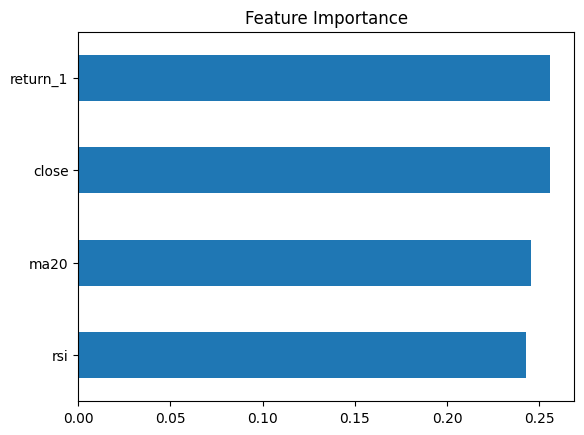

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()
